In [1]:
using DelimitedFiles
using DCAUtils
using PyPlot
using KitMSA
using FastaIO
using Statistics
using StatsBase
using LinearAlgebra

In [2]:
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")

pairwise_hamming (generic function with 1 method)

In [3]:
function seq_DMS(seq, h::Array{Float64,2}, J::Array{Float64,4})
    q = 21
    L = size(seq,1)
    res = zeros(q,L)
    for i in 1:L
        for a in 1:q
            new_seq = deepcopy(seq)
            new_seq[i] = a 
            res[a,i] = delta_energy(h,J, new_seq, seq)
        end
    end
    return res
end

seq_DMS (generic function with 1 method)

In [4]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [5]:
dir_amino = "../../first_fixed_amino_mixed_dbd_steps100_seqs1500_T1.0p0.0"
folder_path = dir_amino

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files];
thornton_wt = Int8.(readdlm("../data/alignments/refs/wt_thornton", '\t')[:]);

 18.324230 seconds (873.07 k allocations: 86.629 MiB, 0.10% gc time, 2.66% compilation time)


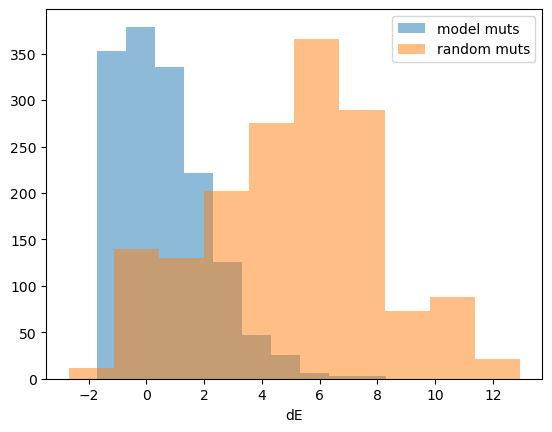

In [6]:
model_muts = [delta_energy(h,J, matr[2,:], thornton_wt) for matr in matrices]
rand_muts = seq_DMS(thornton_wt, h,J)
plt.hist(model_muts[:], alpha = 0.5, label = "model muts")
plt.hist(rand_muts[:], alpha = 0.5, label = "random muts")
plt.xlabel("dE")
plt.legend()
savefig("../model_vs_random_muts.png")

## Insertions & deletions vs. Single nucleotide muts

In [7]:
nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
M,L = size(nat_MSA)

(24944, 76)

In [8]:
function count_gap_to_amino_muts(seq1,seq2)
    L = size(seq1, 1)
    res = 0
    for i in 1:L
        if (seq1[i] == 21 || seq2[i] == 21) && seq1[i] !== seq2[i]
            res += 1
        end
    end
    return res
end

count_gap_to_amino_muts (generic function with 1 method)

In [9]:
#dir_amino = "../data/chains/amino_mixed_dbd_steps600000_seqs100_T1.0p0.5/"
dir_amino = "../../scra_data_beta/sparse_amino_mixed_dbd_steps100000_seqs1000_T1.0p0.5"
folder_path = dir_amino
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files];
step_matrices = build_seq_matrices(matrices);

 13.784854 seconds (668.24 k allocations: 110.610 MiB, 0.24% gc time, 0.67% compilation time)


In [10]:
dir_amino_p0 = "../../scra_data_beta/sparse_amino_mixed_dbd_steps100000_seqs1000_T1.0p0.0"
folder_path_p0 = dir_amino_p0
fasta_files_p0 = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path_p0))
@time matrices_p0 = [Int8.(fasta2matrix(joinpath(folder_path_p0, file))) 
    for file in fasta_files_p0];
step_matrices_p0 = build_seq_matrices(matrices_p0);

  9.496637 seconds (668.24 k allocations: 110.611 MiB, 0.51% gc time, 1.15% compilation time)


In [11]:
tot_dist_sil = []
gap2a_dist_sil = []
n_seq = 1000
sub_MSA = step_matrices[end]
for i in 1:n_seq
    for j in (i+1):n_seq
        push!(tot_dist_sil, count_muts(sub_MSA[i,:], sub_MSA[j,:]))
        push!(gap2a_dist_sil, count_gap_to_amino_muts(sub_MSA[i,:], sub_MSA[j,:]))
    end
end

tot_dist_sil_p0 = []
gap2a_dist_sil_p0 = []
n_seq = 1000
sub_MSA = step_matrices_p0[end]
for i in 1:n_seq
    for j in (i+1):n_seq
        push!(tot_dist_sil_p0, count_muts(sub_MSA[i,:], sub_MSA[j,:]))
        push!(gap2a_dist_sil_p0, count_gap_to_amino_muts(sub_MSA[i,:], sub_MSA[j,:]))
    end
end

tot_dist = []
gap2a_dist = []
n_seq = 1000
sub_MSA = nat_MSA[rand(1:M, n_seq),:]
for i in 1:n_seq
    for j in (i+1):n_seq
        push!(tot_dist, count_muts(sub_MSA[i,:], sub_MSA[j,:]))
        push!(gap2a_dist, count_gap_to_amino_muts(sub_MSA[i,:], sub_MSA[j,:]))
    end
end

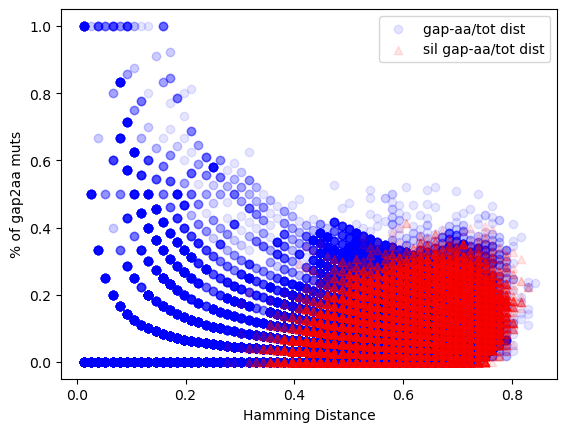

In [12]:
L = length(thornton_wt)
plt.scatter(tot_dist./L, gap2a_dist./(tot_dist), alpha = 0.1, color = "blue", label = "gap-aa/tot dist")
plt.scatter(tot_dist_sil./L, gap2a_dist_sil./(tot_dist_sil), marker = "^", alpha = 0.1, color = "red",
    label = "sil gap-aa/tot dist")
plt.xlabel("Hamming Distance")
plt.ylabel("% of gap2aa muts")
plt.legend()
plt.savefig("../gap_muts.png")

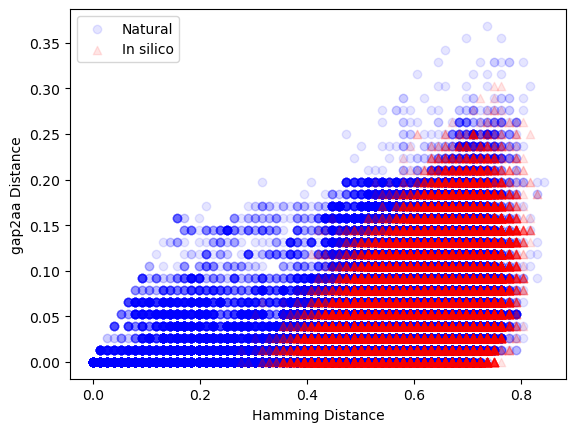

In [23]:
tot_dist_sil = []
gap2a_dist_sil = []
n_seq = 1000
sub_MSA = step_matrices[end]
for i in 1:n_seq
    for j in (i+1):n_seq
        push!(tot_dist_sil, count_muts(sub_MSA[i,:], sub_MSA[j,:]))
        push!(gap2a_dist_sil, count_gap_to_amino_muts(sub_MSA[i,:], sub_MSA[j,:]))
    end
end

L = length(thornton_wt)
plt.scatter(tot_dist./L, gap2a_dist ./L, alpha = 0.1, color = "blue", label = "Natural")
plt.scatter(tot_dist_sil./L, gap2a_dist_sil ./L, marker = "^", alpha = 0.1, color = "red",
    label = "In silico")
plt.xlabel("Hamming Distance")
plt.ylabel("gap2aa Distance")
plt.legend()
plt.savefig("../gap2aa_vs_tot_muts.png")

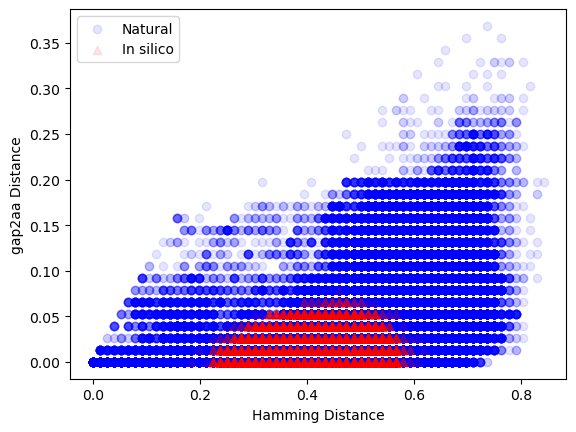

In [24]:
tot_dist_sil = []
gap2a_dist_sil = []
n_seq = 1000
sub_MSA = step_matrices[2]
for i in 1:n_seq
    for j in (i+1):n_seq
        push!(tot_dist_sil, count_muts(sub_MSA[i,:], sub_MSA[j,:]))
        push!(gap2a_dist_sil, count_gap_to_amino_muts(sub_MSA[i,:], sub_MSA[j,:]))
    end
end

L = length(thornton_wt)
plt.scatter(tot_dist./L, gap2a_dist ./L, alpha = 0.1, color = "blue", label = "Natural")
plt.scatter(tot_dist_sil./L, gap2a_dist_sil ./L, marker = "^", alpha = 0.1, color = "red",
    label = "In silico")
plt.xlabel("Hamming Distance")
plt.ylabel("gap2aa Distance")
plt.legend()
plt.savefig("../middle_gap2aa_vs_tot_muts.png")

In [13]:
function one_hot(msa::Array{Int8,2})
    M, N = size(msa)
    new_msa = zeros(M, N*21)
    for i in 1:M
        for j in 1:N
            index = msa[i,j]  
            new_msa[i, (j-1)*21 + index] = 1
        end
    end
    return new_msa
end

function one_hot(seq::Array{Int8,1})
    N = length(seq)
    new_msa = zeros(N*21)
    for j in 1:N
        index = seq[j]  
        new_msa[(j-1)*21 + index] = 1
    end
    return new_msa
end

one_hot (generic function with 2 methods)

In [14]:
wt_DBD = thornton_wt
# one hot encoding of natural alignment
one_hot_nat = one_hot(nat_MSA)
W_nat=DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]

# compute covariance of data
cov_nat = cov(one_hot_nat, pweights(W_nat))

# compute eigenvalues and eigenvectors of covariance matrix
eigenvecs_nat = eigvecs(cov_nat)
eigenvals_nat = eigvals(cov_nat)

# project natural data onto principal components
pc_nat = eigenvecs_nat[:, [end, end-1]]'*one_hot_nat'

# project wts onto natural sequences pcs
oh_anc_dbd = one_hot(wt_DBD)
pc_anc_dbd = eigenvecs_nat[:, [end, end-1]]'*oh_anc_dbd
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [15]:
one_hot_proj = one_hot(step_matrices[end])
pc_vec = eigenvecs_nat[:, [end, end-1]]'*one_hot_proj'

one_hot_proj_p0 = one_hot(step_matrices_p0[end])
pc_vec_p0 = eigenvecs_nat[:, [end, end-1]]'*one_hot_proj_p0'

2×1000 Matrix{Float64}:
 2.85047  2.79558  2.79545  2.70943  …  1.34392   3.25375  2.3895   2.14722
 1.314    1.86177  1.36405  2.22641     0.674069  1.94514  1.88231  1.64824

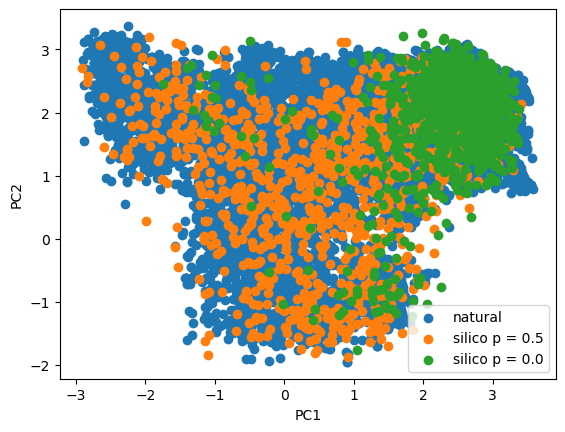

In [16]:
plt.scatter(pc_nat[1,:],pc_nat[2,:], label = "natural")
plt.scatter(pc_vec[1,:], pc_vec[2,:], label = "silico p = 0.5")
plt.scatter(pc_vec_p0[1,:], pc_vec_p0[2,:], label = "silico p = 0.0")
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.legend()
savefig("../pca_p0.5sp0.png")

In [30]:
M = size(nat_MSA,1)
f1_nat,f2_nat = compute_weighted_frequencies(Int8.(nat_MSA[rand(1:M, 1000),:]'), 22, 0.2);
conn_nat = triu(f2_nat .- f1_nat' .* f1_nat, 21);

θ = 0.2 threshold = 15.0
M = 1000 N = 76 Meff = 300.8218277992861


In [31]:
cor1 = []
cor2 = []
cor_conn = []

cor1_p0 = []
cor2_p0 = []
cor_conn_p0 = []


for i in 1:length(step_matrices)
    
    f1,f2 = compute_weighted_frequencies(Int8.(step_matrices[i]'), 22, 0.);
    conn = triu(f2 .- f1' .* f1, 21);
    f1_p0,f2_p0 = compute_weighted_frequencies(Int8.(step_matrices_p0[i]'), 22, 0.);
    conn_p0 = triu(f2_p0 .- f1_p0' .* f1_p0, 21);
    
    push!(cor1, cor(f1[:], f1_nat[:]))
    push!(cor2, cor(f2[:], f2_nat[:]))
    push!(cor_conn, cor(conn[:], conn_nat[:]))
    
    push!(cor1_p0, cor(f1_p0[:], f1_nat[:]))
    push!(cor2_p0, cor(f2_p0[:], f2_nat[:]))
    push!(cor_conn_p0, cor(conn_p0[:], conn_nat[:]))
end

θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 thre

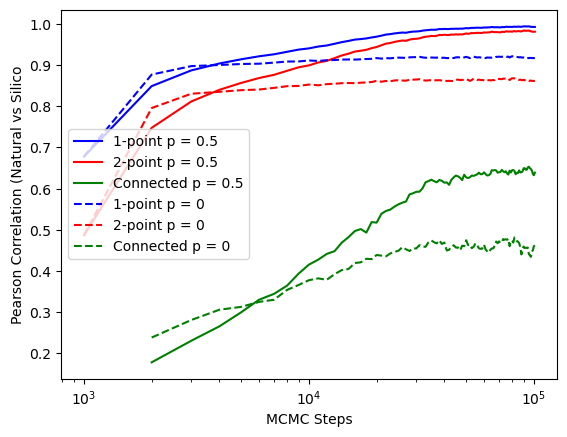

In [39]:
steps = [1000*i for i in 1:101]

plt.plot(steps, cor1, color = "blue", label = "1-point p = 0.5")
plt.plot(steps, cor2, color = "red", label = "2-point p = 0.5")
plt.plot(steps, cor_conn, color = "green", label = "Connected p = 0.5")

plt.plot(steps, cor1_p0, linestyle = "--", color = "blue", label = "1-point p = 0")
plt.plot(steps, cor2_p0, linestyle = "--", color = "red", label = "2-point p = 0")
plt.plot(steps, cor_conn_p0, linestyle = "--", color = "green", label = "Connected p = 0")

plt.legend()

plt.xscale("log")
plt.ylabel("Pearson Correlation (Natural vs Silico")
plt.xlabel("MCMC Steps")

plt.savefig("../p0_performance.png")
